Generating a dataset ...
Training ...


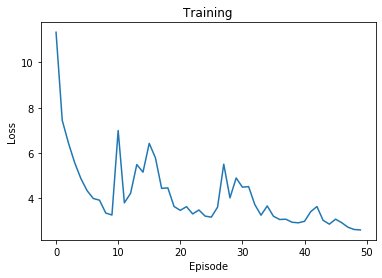

28 35 58 75]
[54 25 86 84 11 10 46 95 60 31] [10 11 25 31 46 54 60 84 86 95] [10 11 25 31 46 54 60 84 86 95]
[50 72 24 43 48 67 69 45 17 79] [17 24 43 45 48 50 67 69 72 79] [17 24 43 45 50 50 67 69 72 79]
[65 98 76 92 41 91 62 72 96 26] [26 41 62 65 72 76 91 92 96 98] [26 41 62 65 72 76 91 91 92 98]
[39 99 86 11  5  8 44 39 43 96] [ 5  8 11 39 39 43 44 86 96 99] [ 5  8 11 39 39 43 43 86 86 99]
[74 63 53 16 79 80 84 96 48 34] [16 34 48 53 63 74 79 80 84 96] [16 34 48 53 63 74 79 80 84 96]
[82 14 30 82 45 92  8 75 39  1] [ 1  8 14 30 39 45 75 82 82 92] [ 1  8 14 30 39 45 75 82 82 92]
[ 5 36 71 98 13 22 95 81 75 15] [ 5 13 15 22 36 71 75 81 95 98] [ 5 13 15 22 36 71 75 81 95 98]
[ 7 96  3 31 19 69 86 79  3 60] [ 3  3  7 19 31 60 69 79 86 96] [ 3  7  7 19 31 60 69 79 86 96]
[72 75 17 57 20 51 83 65 34 55] [17 20 34 51 55 57 65 72 75 83] [17 20 34 51 55 57 65 72 75 83]
[98 14 70 22 73 13 62 56 39 78] [13 14 22 39 56 62 70 73 78 98] [13 14 22 39 56 62 70 78 78 98]
[ 5 15 20 58 89 90 16 87 74

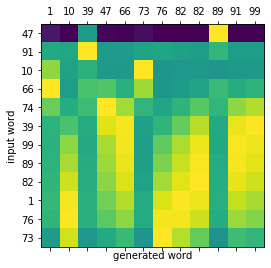

[ 7 23 85  9 83 70 61 17 58 33 35 33] [ 7  9 17 23 33 33 35 58 61 70 83 85] [ 7  9 17 23 33 35 35 58 61 70 83 85]

Attention matrix


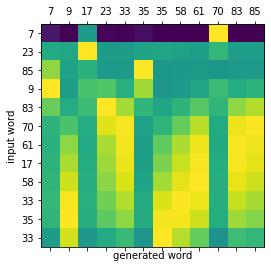

[58 46  6 45 39 74 16 50 64 97  1 62] [ 1  6 16 39 45 46 50 58 62 64 74 97] [ 1  6 16 39 45 46 50 58 62 64 74 97]

Attention matrix


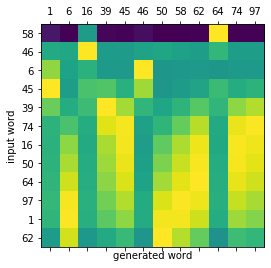

[74  8 89 96 25 69 62 40 99 15 34 28] [ 8 15 25 28 34 40 62 69 74 89 96 99] [ 8 15 25 28 34 40 62 69 74 89 96 99]

Attention matrix


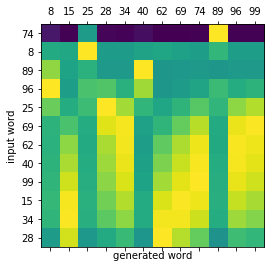

[10 42 57 75 85 58 14 57  6 39 80 66] [ 6 10 14 39 42 57 57 58 66 75 80 85] [ 6 10 14 39 42 57 57 58 66 75 80 85]

Attention matrix


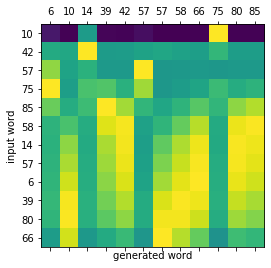

[33 86 18 36  9 71 87 92 60 20 59  9] [ 9  9 18 20 33 36 59 60 71 86 87 92] [ 9  9 18 20 33 36 59 60 71 86 92 92]

Attention matrix


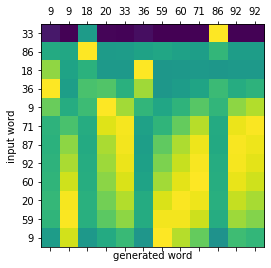

[90 96 52 87 85 56 27 55 85  1 69 32] [ 1 27 32 52 55 56 69 85 85 87 90 96] [ 1 27 32 52 55 56 69 85 85 90 90 96]

Attention matrix


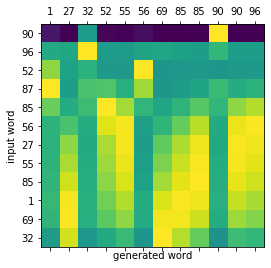

[62 20 93  1 21 78 52 55 34 32 65 24] [ 1 20 21 24 32 34 52 55 62 65 78 93] [ 1 20 21 24 32 34 52 55 62 65 78 93]

Attention matrix


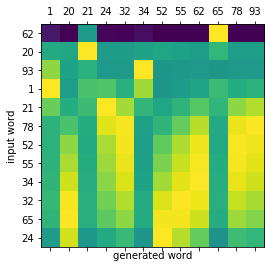

[12 54 17 68 28 39 62 97 49 28 27 84] [12 17 27 28 28 39 49 54 62 68 84 97] [12 17 27 28 28 39 49 54 62 68 84 97]

Attention matrix


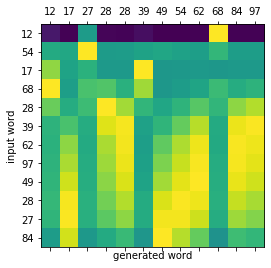

[32 63 82 88 39 70  8 79 73 62 33 30] [ 8 30 32 33 39 62 63 70 73 79 82 88] [ 8 30 33 39 39 62 63 70 79 79 82 88]

Attention matrix


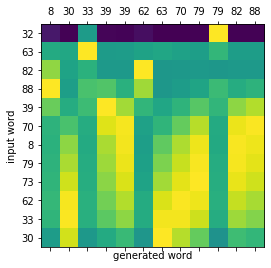

[79  4 82 37 60 19  2 12 37 69 62 47] [ 2  4 12 19 37 37 47 60 62 69 79 82] [ 2  4 12 19 37 37 47 60 62 69 79 82]

Attention matrix


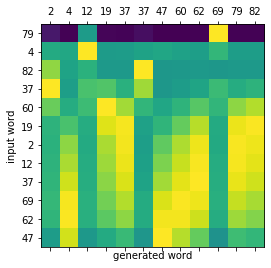

[ 0 93 60 39 68 27 10 12 24 84 56 25] [ 0 10 12 24 25 27 39 56 60 68 84 93] [ 0 10 24 24 27 27 39 56 60 68 84 93]

Attention matrix


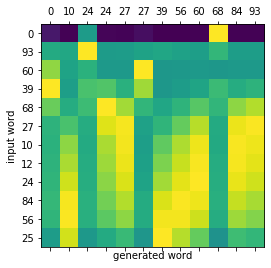

[84 26 29 65 48 78 33 91 47 91 53 64] [26 29 33 47 48 53 64 65 78 84 91 91] [26 29 33 47 48 53 64 65 78 84 91 91]

Attention matrix


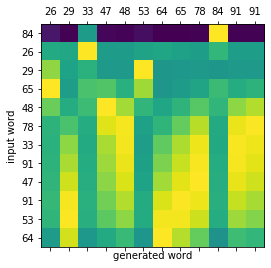

[81 50  8 52  5 93 78 31 36 34 15 24] [ 5  8 15 24 31 34 36 50 52 78 81 93] [ 5  8 15 24 31 36 36 50 52 81 81 93]

Attention matrix


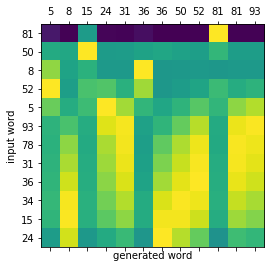

[14 92 21 30 86 27 33 15 46 75 29 32] [14 15 21 27 29 30 32 33 46 75 86 92] [15 21 21 27 29 30 33 33 46 75 86 92]

Attention matrix


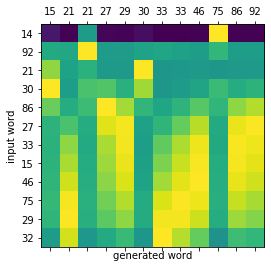

[81 93 12 45 67 52 71 15 38 56  8  0] [ 0  8 12 15 38 45 52 56 67 71 81 93] [ 0  8 15 15 38 45 52 56 67 71 81 93]

Attention matrix


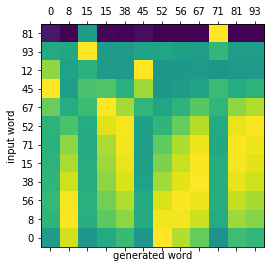

[87 84 46 34 16 53 68 16 64 97 81 96] [16 16 34 46 53 64 68 81 84 87 96 97] [16 16 34 46 53 64 68 81 84 84 96 97]

Attention matrix


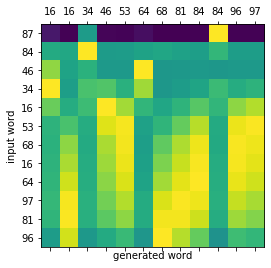

[48 45 77 42 67  3 62 61 42 92 40 47] [ 3 40 42 42 45 47 48 61 62 67 77 92] [ 3 40 40 42 45 47 47 61 67 67 77 92]

Attention matrix


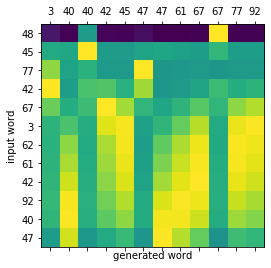

[27  7 22 32 22 65 58 92 70 47 25 80] [ 7 22 22 25 27 32 47 58 65 70 80 92] [ 7 22 22 25 27 32 47 58 65 70 80 92]

Attention matrix


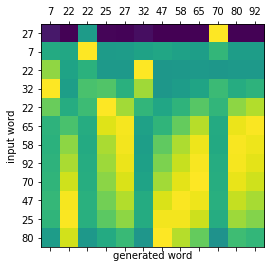

[25 28 40 35 92 33 53 23  3  5 93  9] [ 3  5  9 23 25 28 33 35 40 53 92 93] [ 3  5  9 23 25 28 35 40 40 53 92 93]

Attention matrix


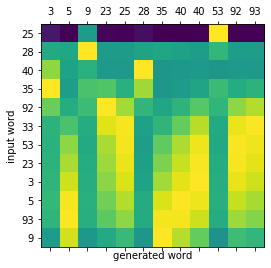

[36 71 84 57 59 12 96 43 34  6 59 29] [ 6 12 29 34 36 43 57 59 59 71 84 96] [ 6 12 29 34 36 43 57 57 59 71 84 96]

Attention matrix


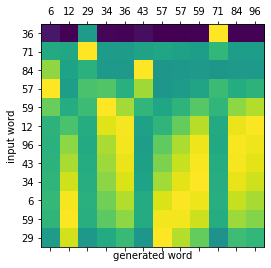

[40 48 88 46  4 98 88 18 42 15 51 14] [ 4 14 15 18 40 42 46 48 51 88 88 98] [ 4 14 18 18 40 42 46 48 51 88 88 98]

Attention matrix


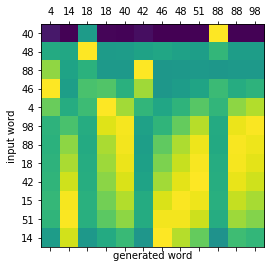

[14 97 35 52 69 45 28 21 95 14 37 37] [14 14 21 28 35 37 37 45 52 69 95 97] [14 21 21 28 35 37 37 45 52 69 95 95]

Attention matrix


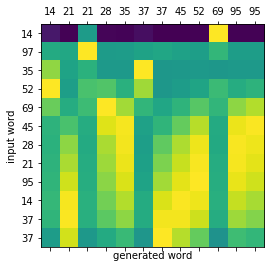

[72 98 86 86 41 22 99 44 44 55 54 88] [22 41 44 44 54 55 72 86 86 88 98 99] [22 41 41 44 54 55 72 86 88 88 99 98]

Attention matrix


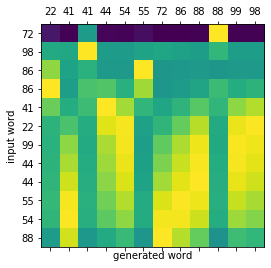

[51 57 70 86 62 31 24 31 15 45 18 38] [15 18 24 31 31 38 45 51 57 62 70 86] [15 18 24 31 31 38 45 51 57 62 70 86]

Attention matrix


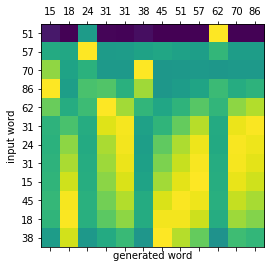

[99 70 36 12  2 39 32 32 65 67 56 65] [ 2 12 32 32 36 39 56 65 65 67 70 99] [ 2 12 32 36 39 39 56 65 65 67 70 99]

Attention matrix


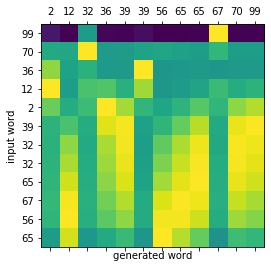

[55 18 97 74 91 31 87  9 82 89 48  1] [ 1  9 18 31 48 55 74 82 87 89 91 97] [ 1  9 18 31 48 55 74 82 87 91 91 97]

Attention matrix


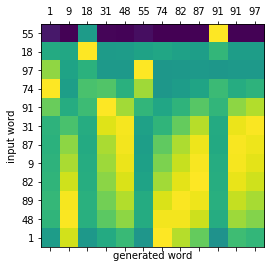

[38 50 12 77 69 25 99 99 52 42 96 55] [12 25 38 42 50 52 55 69 77 96 99 99] [12 25 38 42 50 52 55 69 77 96 96 99]

Attention matrix


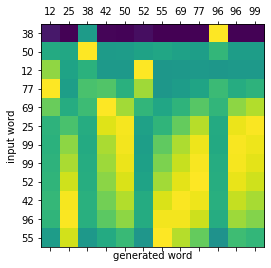

[18 48 63 90 54 22 27 46 84 79 65 21] [18 21 22 27 46 48 54 63 65 79 84 90] [18 21 22 27 46 48 54 63 65 79 84 90]

Attention matrix


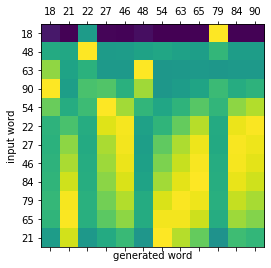

[34 19 93 86 36 79 76 26 85 85 66 43] [19 26 34 36 43 66 76 79 85 85 86 93] [19 26 34 36 43 66 76 79 79 86 93 93]

Attention matrix


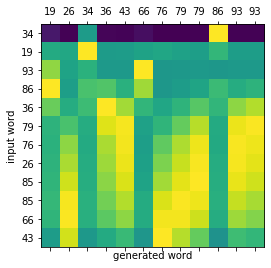

[69 59 47 76 82 42 27 65 88 36 38 69] [27 36 38 42 47 59 65 69 69 76 82 88] [27 36 38 42 47 59 65 69 69 76 82 88]

Attention matrix


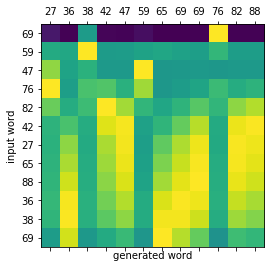

[75 54 92 28 64 19 78 33 99 25 44 29] [19 25 28 29 33 44 54 64 75 78 92 99] [19 25 28 29 33 44 54 64 75 78 92 99]

Attention matrix


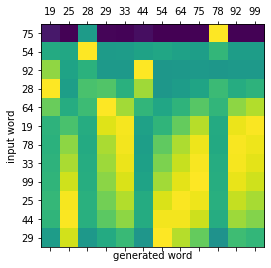

[95 82 74 58 66 89  0  1 21 43  9 48] [ 0  1  9 21 43 48 58 66 74 82 89 95] [ 0  1  9 21 43 48 58 66 74 82 89 95]

Attention matrix


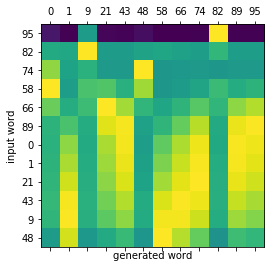

[39 13 19 14 71 17 33  1 94 54 51  9] [ 1  9 13 14 17 19 33 39 51 54 71 94] [ 1  9 13 17 19 19 33 39 51 54 71 94]

Attention matrix


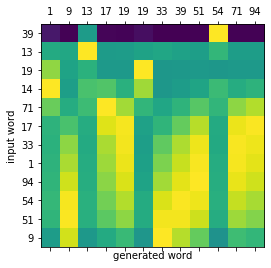

[80 13 36 35 64 22 74 71  1 33  7 57] [ 1  7 13 22 33 35 36 57 64 71 74 80] [ 1  7 13 22 33 36 36 57 64 71 80 80]

Attention matrix


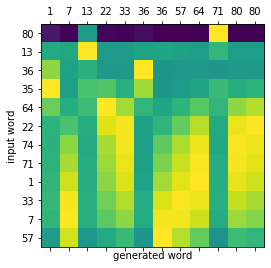

[90 78 86 93 40  9 32 61 56  2 31 22] [ 2  9 22 31 32 40 56 61 78 86 90 93] [ 2  9 22 31 32 40 56 61 78 86 90 93]

Attention matrix


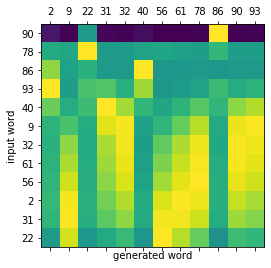

[62 85 50 60 81 73 65 94  6 24  2 63] [ 2  6 24 50 60 62 63 65 73 81 85 94] [ 2  6 24 50 60 60 65 73 73 81 85 94]

Attention matrix


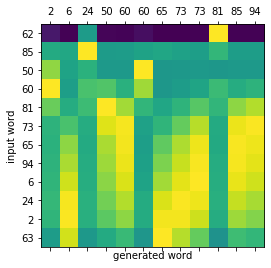

[72 66 41 51 99 15 37 60 90 14 76 75] [14 15 37 41 51 60 66 72 75 76 90 99] [14 15 37 41 51 60 66 72 76 76 90 99]

Attention matrix


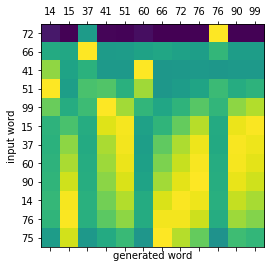

[81 91 30 47 29 49  8  4 99 38 63 55] [ 4  8 29 30 38 47 49 55 63 81 91 99] [ 4  8 29 30 38 47 49 55 63 81 91 99]

Attention matrix


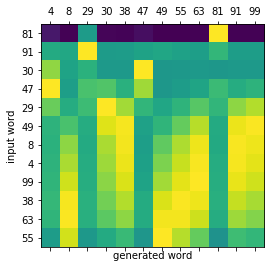

[18 89  3 43 67 65  0 88 36 10 33 20] [ 0  3 10 18 20 33 36 43 65 67 88 89] [ 0  3 10 18 20 33 36 43 65 67 88 89]

Attention matrix


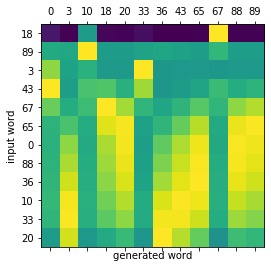

[64 12 84  3 18 35 45 73 63  7 70 82] [ 3  7 12 18 35 45 63 64 70 73 82 84] [ 3  7 12 18 35 45 63 64 70 73 82 84]

Attention matrix


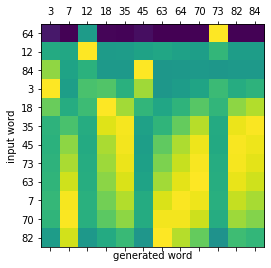

[23 95 98 52 23 98 42 70 44 26 61  8] [ 8 23 23 26 42 44 52 61 70 95 98 98] [ 8 23 23 26 42 44 52 61 70 95 98 98]

Attention matrix


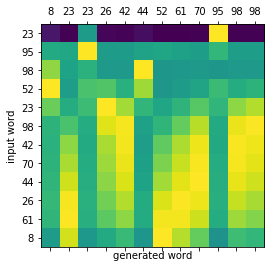

[39 58 33 54 78 17 88 88 35 31 16 56] [16 17 31 33 35 39 54 56 58 78 88 88] [16 17 31 35 39 39 54 56 58 78 88 88]

Attention matrix


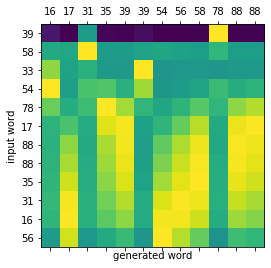

[ 0 94 78 90 71 38 95 86 35 50 47 35] [ 0 35 35 38 47 50 71 78 86 90 94 95] [ 0 35 38 38 47 50 71 78 86 90 95 95]

Attention matrix


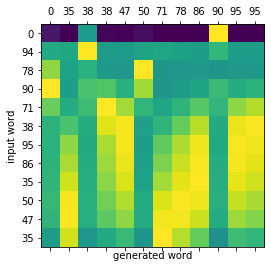

[41 20 51 91 50 10 94 15 11 58 83 11] [10 11 11 15 20 41 50 51 58 83 91 94] [10 11 15 20 20 41 50 51 58 83 91 94]

Attention matrix


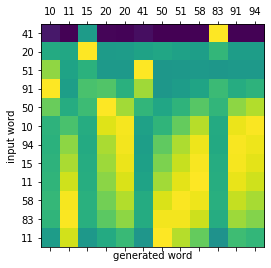

[48 97 94 68 16 76 63 85 14 35 66 53] [14 16 35 48 53 63 66 68 76 85 94 97] [14 16 35 48 53 63 68 68 76 85 94 97]

Attention matrix


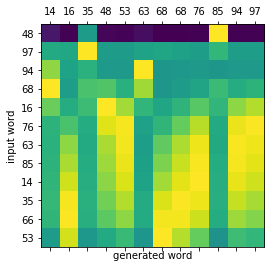

[23 51 10 50 96 17 73 36 60 11 98 89] [10 11 17 23 36 50 51 60 73 89 96 98] [10 17 17 23 36 50 50 60 73 89 96 98]

Attention matrix


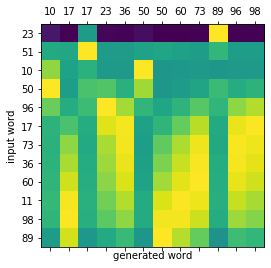

[ 9 53 35 43 71 66 98 90 24 45 99  5] [ 5  9 24 35 43 45 53 66 71 90 98 99] [ 5  9 24 35 43 45 53 66 71 90 90 99]

Attention matrix


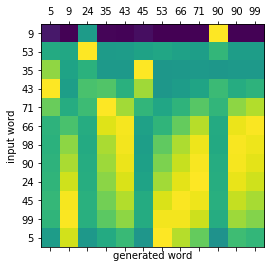

[70 57 81 40 26 80 58 64 13 93 34 65] [13 26 34 40 57 58 64 65 70 80 81 93] [13 26 34 40 57 58 64 70 70 80 81 93]

Attention matrix


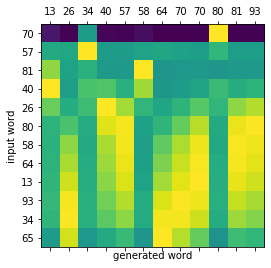

[41 40 95 83 85 89 81 61 31 37 31 63] [31 31 37 40 41 61 63 81 83 85 89 95] [31 37 37 40 41 61 63 81 81 85 95 95]

Attention matrix


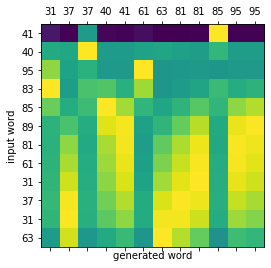

[99 40 29 92 68 49 94 87 20 33 11 10] [10 11 20 29 33 40 49 68 87 92 94 99] [10 20 20 29 33 40 49 68 87 87 92 99]

Attention matrix


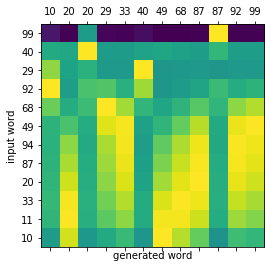

[65 17  4 60 24 82 15 60 71  7 77 76] [ 4  7 15 17 24 60 60 65 71 76 77 82] [ 4  7 15 17 24 60 60 65 71 76 82 82]

Attention matrix


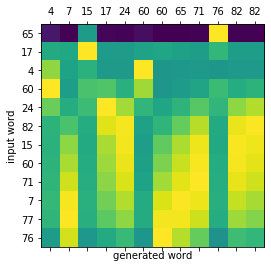

[79 76 86 86  4 53 49 45 88 40 21 99] [ 4 21 40 45 49 53 76 79 86 86 88 99] [ 4 21 40 45 49 53 79 79 86 88 99 99]

Attention matrix


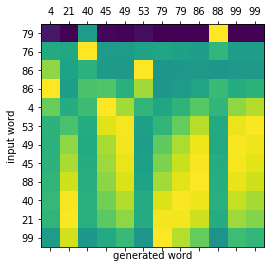

[46 71 44 94 37 74  7 28 35 57 86  2] [ 2  7 28 35 37 44 46 57 71 74 86 94] [ 2  7 28 35 37 44 46 57 71 74 86 94]

Attention matrix


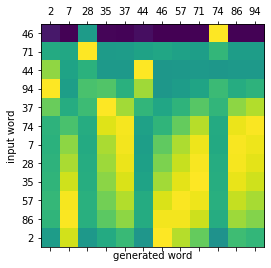

[87  0  6 42 54 18 11 95 13 13 72 86] [ 0  6 11 13 13 18 42 54 72 86 87 95] [ 0  6 11 13 18 18 42 54 72 87 86 95]

Attention matrix


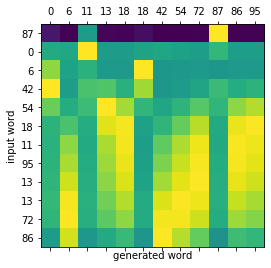

[17 87 21 56 69 94 83 77 86 71 34 33] [17 21 33 34 56 69 71 77 83 86 87 94] [17 21 33 34 56 69 77 77 83 86 94 94]

Attention matrix


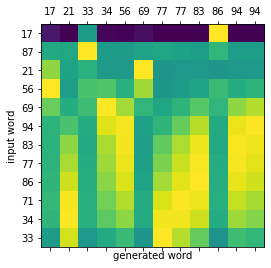

[48 72 72 67 74  2 64  4 14 94 37 29] [ 2  4 14 29 37 48 64 67 72 72 74 94] [ 2  4 14 29 37 48 64 67 72 74 74 94]

Attention matrix


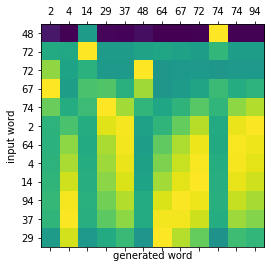

[33 44 69 26 79 22 25  8 50 21 69 38] [ 8 21 22 25 26 33 38 44 50 69 69 79] [ 8 21 22 25 33 33 38 44 50 69 69 79]

Attention matrix


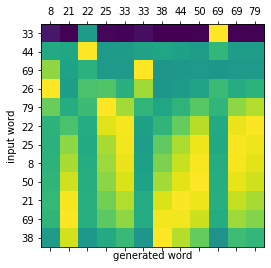

[17  2 33 50 99 39 23 18  8 39 32 68] [ 2  8 17 18 23 32 33 39 39 50 68 99] [ 2  8 18 23 23 32 33 39 39 50 68 99]

Attention matrix


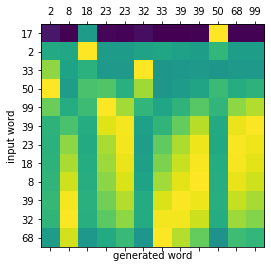

[67 71 43 44 44 44 39 50 85 60 97 25] [25 39 43 44 44 44 50 60 67 71 85 97] [25 39 39 43 44 44 50 60 67 71 85 97]

Attention matrix


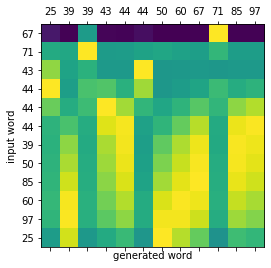

[72 60 16  9  3 74 64 49 72 51 96 98] [ 3  9 16 49 51 60 64 72 72 74 96 98] [ 3  9 16 49 51 60 64 72 74 74 96 98]

Attention matrix


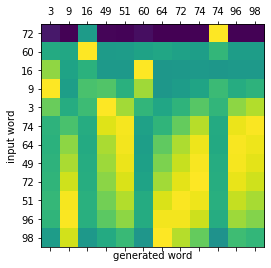

[20  7 97 16 80  8 72  5 63 79 80  2] [ 2  5  7  8 16 20 63 72 79 80 80 97] [ 2  5  8 16 20 20 63 72 79 79 80 97]

Attention matrix


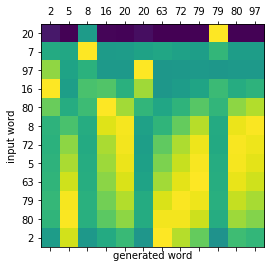

[50 61 11 45 41 58 77 67 43 59 14 76] [11 14 41 43 45 50 58 59 61 67 76 77] [11 14 41 41 45 50 58 58 61 67 77 77]

Attention matrix


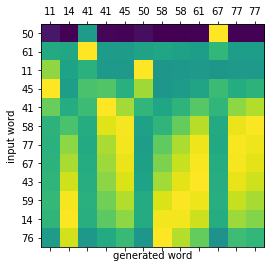

[36 17 24 38 23 31 91 99 51 81 76 72] [17 23 24 31 36 38 51 72 76 81 91 99] [17 23 24 31 36 38 51 72 76 81 91 99]

Attention matrix


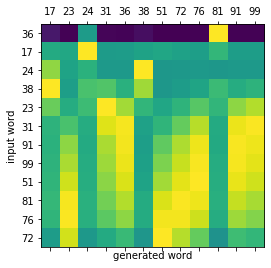

In [6]:
""" 
Pointer networks example
"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100]
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 50000
EPOCHS = 50


VALIDATION_RATIO = .2


def plot_attention(attention, input_word, generated_word, size_=(10,12)):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    plt.xlabel('generated word')
    plt.xticks(range(size_[0]),generated_word)
    plt.ylabel('input word')
    plt.yticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)
    # train-validate spilit
    ds_len = len(ds)
    indexes = list(range(ds_len))
    random.shuffle(indexes) # shuffle them
    spilit_spot = int(math.floor(VALIDATION_RATIO * ds_len))
    
    train_indexes = indexes[spilit_spot:]
    validation_indexes = indexes[:spilit_spot]

    # samples 
    train_sampler = SubsetRandomSampler(train_indexes)
    validation_sampler = SubsetRandomSampler(validation_indexes)

    # loaders
    train_dataloader = DataLoader(ds,
                            sampler=train_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)

    validation_dataloader = DataLoader(ds,
                            sampler=validation_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)
    


    # The Pointer Network model
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0005)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            _, sequence_length = batch.shape
            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #back propagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to check how store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()


    ################## Validation #############
    print('\nValidation ...\n')
    print('\ninput\ttarget\tpointer')
    pointer_network.eval()
    for batch, target_sequences in validation_dataloader:
        if batch.shape[0] < BATCH_SIZE:
            break # ignore last small batch, can be padded although
        batch = batch.unsqueeze(2).float() # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])

     ################## Testing #############
    print('\n\n\n Testing of higher length 12')
    print('\ninput\ttarget\tpointer')
    ds = SortingDataset(range_=RANGE, lengths=[12], SOS_SYMBOL=SOS_SYMBOL, num_instances=100)
    test_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)
    for batch, target_sequences in test_dataloader:
        if batch.shape[0] < BATCH_SIZE:
            break # ingonre last small batch, can be padded although
        batch = batch.unsqueeze(2).float() # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(12, 12))


if __name__ is '__main__':
    main()
